In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from common import data
from common.training import training_loop, get_predictions

from algos import cbl
from algos.supervised import SupervisedEngine

from common.models import simple_conv
from common import metrics
from common.models.modutils import load_model


c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Hyperparameters

In [21]:
log_dir = "./final/cbl_simple_2"

horizon = 1024
stride = 512

batch_size_con = 8
batch_size_sup = 16

num_epochs_con = 10
num_epochs_sup = 5

learning_rate_con = 1e-3
learning_rate_sup = 1e-3

weight_decay_con = 1e-1
weight_decay_sup = 1e-2

supervised_percentage = 0.25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Contrastive

## Datasets

In [4]:
paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)


In [5]:
m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.STANDARD)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.STANDARD)


Loading: 100%|██████████| 25/25 [00:15<00:00,  1.67it/s]


In [6]:
train_loader = DataLoader(
    data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride),
    batch_size_con,
    shuffle=True,
)
test_loader = DataLoader(
    data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride),
    batch_size_con,
    shuffle=False,
)


## Model

In [7]:
base_width = 128
down_layers = 2
dilations = [False, True]

backbone = simple_conv.Encoder(data.NUM_FEATURES, down_layers, base_width, dilations)

optim = AdamW(backbone.parameters(), lr=learning_rate_con, weight_decay=weight_decay_con)
lr_sched = CosineAnnealingLR(optim, num_epochs_con)

aug = cbl.pipeline(
    cbl.random_apply(cbl.left_to_right_flipping(1), 0.5),
    cbl.random_apply(cbl.crop_and_resize(1.5, 3), 0.8),
)

engine_contrastive = cbl.CBLEnginePermute(
    model=backbone,
    optimizer=optim,
    temperature=0.5,
    aug_1=aug,
    aug_2=aug,
    lr_scheduler=lr_sched,
    device=device,
)


## Training

In [8]:
with SummaryWriter(log_dir + "/contrastive/logs") as writer:
    training_loop(
        engine=engine_contrastive,
        num_epochs=num_epochs_con,
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        writer=writer,
        save_path=log_dir + "/contrastive/models",
    )


Epoch 0 - train_loss=1.464 - test_loss=2.202 - lr=1.00e-03


Epoch 1 - train_loss=1.333 - test_loss=2.174 - lr=9.76e-04


Epoch 2 - train_loss=1.366 - test_loss=2.155 - lr=9.05e-04


Epoch 3 - train_loss=1.362 - test_loss=2.154 - lr=7.94e-04


Epoch 4 - train_loss=1.278 - test_loss=2.152 - lr=6.55e-04


Epoch 5 - train_loss=1.390 - test_loss=2.149 - lr=5.00e-04


Epoch 6 - train_loss=1.346 - test_loss=2.147 - lr=3.45e-04


Epoch 7 - train_loss=1.345 - test_loss=2.131 - lr=2.06e-04


Epoch 8 - train_loss=1.183 - test_loss=2.116 - lr=9.55e-05


Epoch 9 - train_loss=1.222 - test_loss=2.117 - lr=2.45e-05


# Supervised

## Dataset

In [9]:
n_samples = int(len(test) * supervised_percentage)
m_data_train.data = m_data_train.data[:n_samples]

sup_loader = DataLoader(
    data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride),
    batch_size_sup,
    shuffle=True,
)


## Model

In [12]:
load_model(backbone, log_dir + "/contrastive/models/backbone_9.pth", device);

for p in backbone.parameters():
    p.requires_grad = False

model = simple_conv.SimpleSegConv(backbone, 1)

optim = AdamW(
    (p for p in model.parameters() if p.requires_grad), lr=learning_rate_sup, weight_decay=weight_decay_sup
)
lr_sched = CosineAnnealingLR(optim, num_epochs_sup)
engine_supervised = SupervisedEngine(
    model, device, optimizer=optim, lr_scheduler=lr_sched
)


## Training

In [13]:
with SummaryWriter(log_dir + "/supervised/logs") as writer:
    training_loop(
        engine=engine_supervised,
        num_epochs=num_epochs_sup,
        train_dataloader=sup_loader,
        test_dataloader=test_loader,
        writer=writer,
        save_path=log_dir + "/supervised/models",
    )


Epoch 0 - train_loss=0.503 - test_loss=0.593 - cost=0.173 - threshold=-0.041 - lr=1.00e-03


Epoch 1 - train_loss=0.347 - test_loss=0.428 - cost=0.197 - threshold=-0.348 - lr=9.05e-04


Epoch 2 - train_loss=0.276 - test_loss=0.309 - cost=0.195 - threshold=-0.364 - lr=6.55e-04


Epoch 3 - train_loss=0.270 - test_loss=0.279 - cost=0.189 - threshold=-1.049 - lr=3.45e-04


Epoch 4 - train_loss=0.221 - test_loss=0.250 - cost=0.180 - threshold=-1.213 - lr=9.55e-05


# Evaluating

In [14]:
load_model(model, log_dir + "/supervised/models/model_4.pth", device);

In [15]:
# Cost model
cmodel = metrics.default_cmodel()


In [16]:
scores, labels = get_predictions(engine_supervised.predict, test_loader)


100%|██████████| 81/81 [00:05<00:00, 14.34it/s]


In [17]:
cmodel.fit(scores, labels).optimize()


(-1.2129500055312867, 0.18011314)

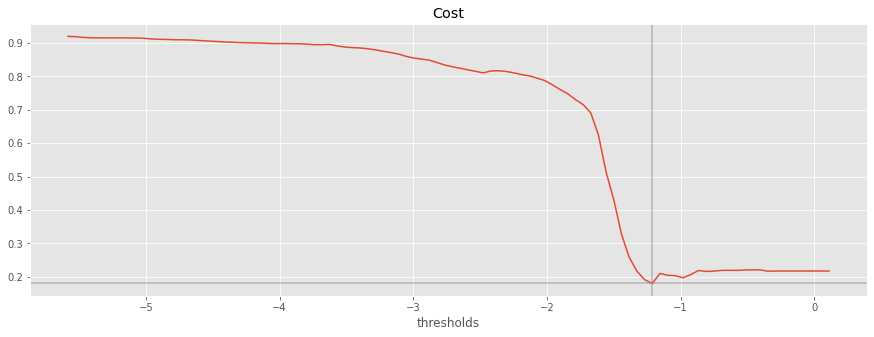

In [18]:
metrics.plot_cost(cmodel)


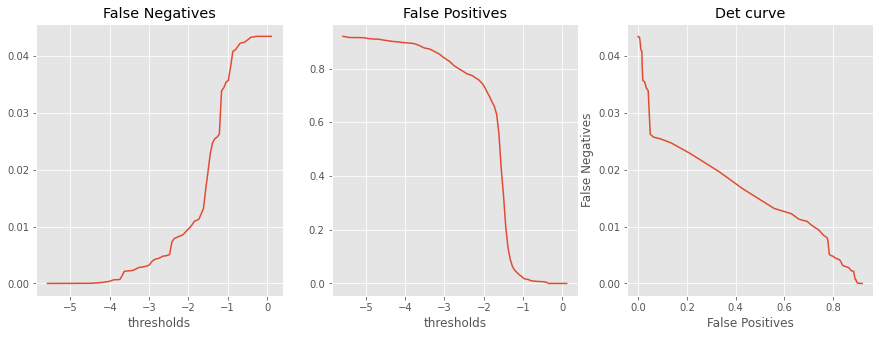

In [19]:
metrics.plot_errors_curve(
    cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5)
)


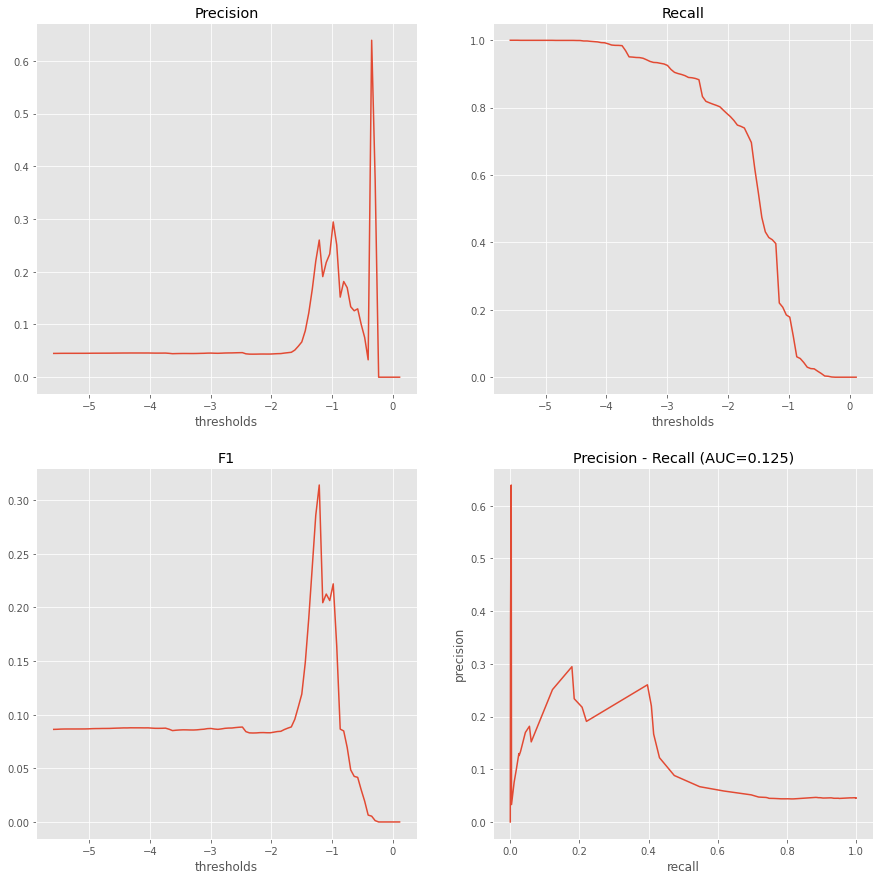

In [20]:
pr, rec, f1 = metrics.precision_recall_f1(
    cmodel.false_positives, cmodel.false_negatives
)
metrics.plot_precision_recall_f1_curve(pr, rec, f1, cmodel.thresholds)